In [ ]:
# inspired by lazyprogrammer


import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import os

from skimage.io import imread


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image



In [ ]:
# makes pixel values between -1 and +1
# assume they are transformed from (0, 1)

# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])
                         

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)
    

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [ ]:
len(train_dataset)

60000

In [ ]:
batch_size = 128

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)
                                          

In [ ]:
# Discriminator

D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)


In [ ]:
# Generator


latent_dim = 100

G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

D = D.to(device)
G = G.to(device)


In [ ]:
criterion = nn.BCEWithLogitsLoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def scale_image(img):
  
  out = (img + 1) / 2    # scale image back to (0, 1)

  return out



In [ ]:
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

d_losses = []
g_losses = []



for epoch in range(200):


  for inputs, _ in data_loader:

    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    ones = ones_[:n]
    zeros = zeros_[:n]



    ###########################
    ### Train discriminator ###
    ###########################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    #######################
    ### Train generator ###
    #######################

    for _ in range(2):  # do it twice

      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      g_loss = criterion(fake_outputs, ones)  # reverse the labels

      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()



    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())



  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")


  
  fake_images = fake_images.reshape(-1, 1, 28, 28)

  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")  # save a batch of images to file



Epoch: 0, d_loss: 0.68047034740448, g_loss: 0.6662955284118652
Epoch: 1, d_loss: 0.7071035504341125, g_loss: 0.8107303380966187
Epoch: 2, d_loss: 0.6876696348190308, g_loss: 0.7310963869094849
Epoch: 3, d_loss: 0.6825389862060547, g_loss: 0.7769100069999695
Epoch: 4, d_loss: 0.6889893412590027, g_loss: 0.7556778788566589
Epoch: 5, d_loss: 0.682299017906189, g_loss: 0.7201077938079834
Epoch: 6, d_loss: 0.6838651895523071, g_loss: 0.740240752696991
Epoch: 7, d_loss: 0.6866905689239502, g_loss: 0.727881908416748
Epoch: 8, d_loss: 0.6904422044754028, g_loss: 0.6928049921989441
Epoch: 9, d_loss: 0.6933594942092896, g_loss: 0.7346236705780029
Epoch: 10, d_loss: 0.6938905715942383, g_loss: 0.722802996635437
Epoch: 11, d_loss: 0.6922292709350586, g_loss: 0.7095546126365662
Epoch: 12, d_loss: 0.6857796907424927, g_loss: 0.721759021282196
Epoch: 13, d_loss: 0.7025293111801147, g_loss: 0.7216035723686218
Epoch: 14, d_loss: 0.6925420761108398, g_loss: 0.7016552686691284
Epoch: 15, d_loss: 0.685800

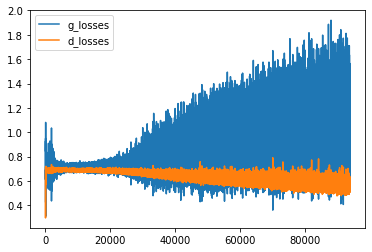

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

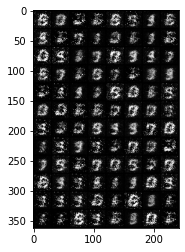

In [ ]:
a = imread('gan_images/1.png')
plt.imshow(a)

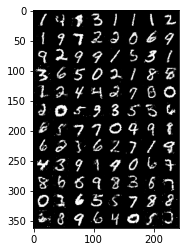

In [ ]:
a = imread('gan_images/50.png')
plt.imshow(a)

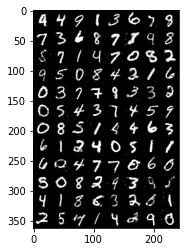

In [ ]:
a = imread('gan_images/100.png')
plt.imshow(a)

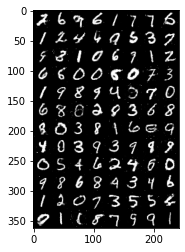

In [ ]:
a = imread('gan_images/150.png')
plt.imshow(a)

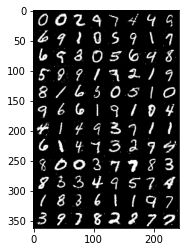

In [ ]:
a = imread('gan_images/200.png')
plt.imshow(a)